In [1]:
%matplotlib inline

# import
import numpy as np
import pandas as pd
import autograd_extended
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import LSTM, Input, Lambda, Dense, RepeatVector
from keras import backend as K
from keras import objectives

Using TensorFlow backend.


# Training the latent ODE model
<strong>From appendix D</strong>

To obtain the latent representation $z_{t_{0}}$, we traverse using RNN and obtain parameters of distribution $ q(\textbf{z}_{t_{0}} | \{ \textbf{x}_{t_{i}}, t_{i} \}_{i}, \theta_{enc})$. The algorithm is the following:


## Step 1
Run an RNN encoder through the time series and infer the parameters for the a posterior over $ \textbf{z}_{t_{0}}$:
$$ q(\textbf{z}_{t_{0}} | \{ \textbf{x}_{t_{i}}, t_{i} \}_{i}, \phi) = \mathcal{N}(\textbf{z}_{t_{0}} | \mu_{\textbf{z}_{t_{0}}}, \sigma_{\textbf{z}_{0}}) $$

where $\mu_{z_{0}}, \sigma_{z_{0}}$ comes from hidden state of $ RNN(\{ \textbf{x}_{t_{i}} , t_{i} \}_{i}, \phi) $

## Step 2
Sample $ \textbf{z}_{t_{0}} \sim q(\textbf{z}_{t_{0}} | \{ \textbf{x}_{t_{i}}, t_{i} \}_{i}) $

In [2]:
# Process Data

# obtain simple time series with sine function
df = pd.read_csv('./data.csv')

x, y = df["x"], df["y"]

# split y into timesteps for training (-1, 100, 1) we use a sliding window
timesteps = 5

newY = []
for i in range(0, len(y)-timesteps):
    temp = y[i:i+timesteps]
    
    temp_ls = []
    for j in temp:
        temp_ls.append([j])
    newY.append(temp_ls)
    
y = np.array(newY)

Define and run the autoencoder model

In [3]:
# Run an RNN encoder on the time series

# Params
timesteps = 5
input_dim = 1
lstm_dim = 32
latent_dim = 100
batch_size = 1

# Encoder model
def sample_z(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


# Input
inputs = Input(shape=(timesteps, input_dim,), name='encoder_input')

# LSTM encoding
h = LSTM(lstm_dim)(inputs)

# VAE Z layer
z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim)(h)

# Obtain z
z = Lambda(sample_z, output_shape=(latent_dim,))([z_mean, z_log_sigma])

encoder = Model(inputs, z_mean, name="encoder")

# Decoder model
decoder_h = LSTM(lstm_dim, return_sequences=True)
decoder_mean = LSTM(input_dim, return_sequences=True)

h_decoded = RepeatVector(timesteps)(z)
h_decoded = decoder_h(h_decoded)

# decoded layer
outputs = decoder_mean(h_decoded)

# decoder, from latent space to reconstructed inputs
decoder_inputs = Input(shape=(latent_dim,))

_h_decoded = RepeatVector(timesteps)(decoder_inputs)
_h_decoded = decoder_h(_h_decoded)

decoder_outputs = decoder_mean(_h_decoded)

decoder = Model(decoder_inputs, decoder_outputs)

# Build vae
vae = Model(inputs, outputs, name='vae_lstm')
def vae_loss(x, x_decoded_mean):
    xent_loss = objectives.mse(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma))
    loss = xent_loss + kl_loss
    return loss

vae.compile(optimizer='adam', loss=vae_loss)

encoder.summary()
decoder.summary()
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 5, 1)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                4352      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               3300      
Total params: 7,652
Trainable params: 7,652
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 5, 100)            0         
_________________________________________________________________
lstm_2 (

In [4]:
# Train the VAE to obtain z
vae.fit(y, y, epochs=20)

Epoch 1/20
1995/1995 [==============================] - 6s 3ms/step - loss: 0.5021
Epoch 2/20
1995/1995 [==============================] - 2s 1ms/step - loss: 0.4749
Epoch 3/20
1995/1995 [==============================] - 2s 1ms/step - loss: 0.4643
Epoch 4/20
1995/1995 [==============================] - 2s 1ms/step - loss: 0.4568
Epoch 5/20
1995/1995 [==============================] - 2s 1ms/step - loss: 0.4422
Epoch 6/20
1995/1995 [==============================] - 2s 1ms/step - loss: 0.3795
Epoch 7/20
1995/1995 [==============================] - 2s 1ms/step - loss: 0.2682
Epoch 8/20
1995/1995 [==============================] - 2s 1ms/step - loss: 0.2233
Epoch 9/20
1995/1995 [==============================] - 2s 1ms/step - loss: 0.2022
Epoch 10/20
1995/1995 [==============================] - 2s 1ms/step - loss: 0.1923
Epoch 11/20
1995/1995 [==============================] - 2s 1ms/step - loss: 0.1809
Epoch 12/20
1995/1995 [==============================] - 2s 1ms/step - loss: 0.1736
E

x: (1995, 5, 1), preds: (1995, 5, 1)


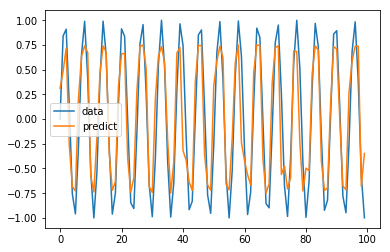

In [7]:
# Sanity check, we should get a sine graph
prediction = vae.predict(y, batch_size=batch_size)

# pick a column to plot.
print("x: %s, preds: %s" % (y.shape, prediction.shape))
plt.plot(y[:100,0,0], label='data')
plt.plot(prediction[:100,0,0], label='predict')
plt.legend()
plt.show()


## Step 3
Obtain $\textbf{z}_{t_{1}}, \textbf{z}_{t_{2}}, ..., \textbf{z}_{t_{M}} $ by solving ODE $ ODESolve(\textbf{z}_{t_{0}}, f, \theta_{f}, t_{0},...,t_{M})$ where $f$ is the function defining the gradient $d\textbf{z}/{dt}$ as a function of $\textbf{z}$

In [ ]:
# TODO

## Step 4
Maximize ELBO (Evidence Lower Bound) 
$$ ELBO = \sum^{M}_{i=1}
        {
             \log p(\textbf{x}_{t_{i}}) | \textbf{z}_{t_{i}}, \theta_{\textbf{x}} ) 
             + \log p(\textbf{z}_{t_{0}})
             - \log q(\textbf{z}_{t_{0}} | \{ \textbf{x}_{t_{i}}, t_{i} \}_{i}, \phi)
        }  
$$

Where $p(\textbf{z}_{t_{0}}) = \mathcal{N}(0,1)$

In [ ]:
# TODO